## Section 4.2.1 Representing a function with basis expansions

Loading required package: gamair


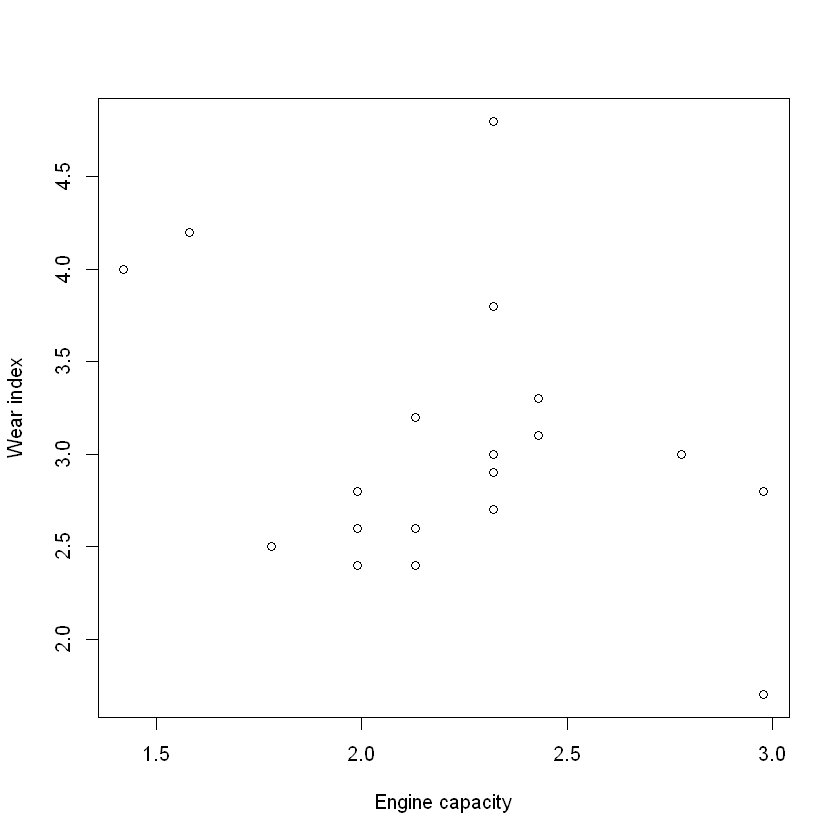

In [3]:
require(gamair)
data(engine)
attach(engine)
plot(size, wear, xlab="Engine capacity", ylab="Wear index")

In [4]:
tf <- function(x, xj, j){
    ## generate the jth tent function from set defined by knots xj
    dj <- xj*0
    dj[j] <- 1
    approx(xj, dj, x)$y
}

In [5]:
tf.X <- function(x, xj){
    ## tent function basis matrix given data x
    ## and knot sequence xj
    nk <- length(xj)
    n <- length(x)
    X <- matrix(NA, n, nk)
    for (j in 1:nk) X[,j] <- tf(x, xj, j)
    X
}

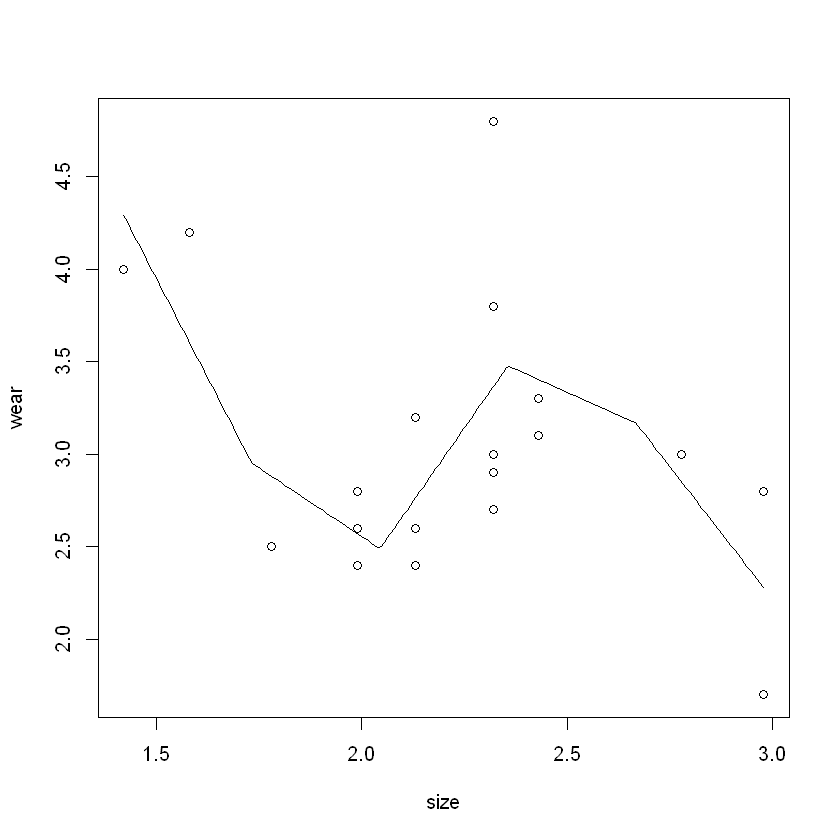

In [6]:
sj <- seq(min(size), max(size), length=6) # generate knots
X <- tf.X(size, sj) # get model matrix
b <- lm(wear ~ X - 1) # git model 
s <- seq(min(size), max(size), length=200) #prediction data
Xp <- tf.X(s, sj) # prediction matrix
plot(size, wear) # plot data overlay
lines(s, Xp %*% coef(b)) # estimated f

## Section 4.2.2 Controlling Smoothness by Penalizing Wiggliness

In [7]:
prs.fit <- function(y, x, xj, sp) {
    X <- tf.X(x, xj)   ## model matrix
    D <- diff(diag(length(xj)), differences=2)   ## sqrt penalty
    X <- rbind(X, sqrt(sp)*D)   ## augmented model matrix
    y <- c(y, rep(0, nrow(D)))   ## augmented data
    lm(y ~ X - 1)   ## penalized least squares fit
}

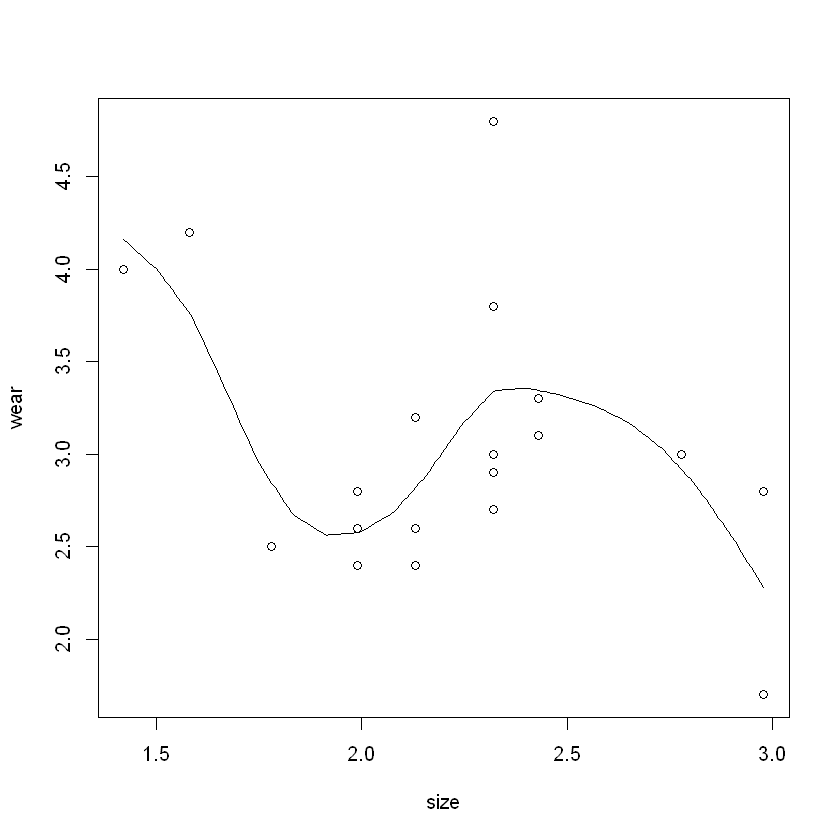

In [8]:
sj <- seq(min(size), max(size), length=20)   ## knots
b <- prs.fit(wear, size, sj, 2)   ## penalized fit
plot(size, wear)   ## plot data
Xp <- tf.X(s, sj)   ## prediction matrix
lines(s, Xp %*% coef(b))   ## plot the smooth

## Section 4.3.1 Penalized piecewise regression representation of an additive model

In [10]:
tf.XD <- function(x, xk, cmx=NULL, m=2) {
    ## get X and D subject to constraint
    nk <- length(xk)
    X <- tf.X(x, xk)[,-nk]   ## basis matrix
    D <- diff(diag(nk), differences=m)[,-nk]   ## root penalty
    if (is.null(cmx)) cmx <- colMeans(X)
    x <- sweep(X, 2, cmx)   ## subtract cmx from columns
    list(X=X, D=D, cmx=cmx)
}

## Section 4.3.2 Fitting additive models by penalized least squares

In [11]:
am.fit <- function(y, x, v, sp, k=10) {
    ## setup bases and penalties...
    xk <- seq(min(x), max(x), length=k)
    xdx <- tf.XD(x, xk)
    vk <- seq(min(v), max(v), length=k)
    xdv <- tf.XD(v, vk)
    ## create augmented model matrix and response
    nD <- nrow(xdx$D)*2
    sp <- sqrt(sp)
    X <- cbind(c(rep(1,nrow(xdx$X)), rep(0, nD)),
              rbind(xdx$X, sp[1]*xdx$D, xdv$D*0),
              rbind(xdv$X, xdx$D*0, sp[2]*xdv$D))
    y1 <- c(y, rep(0, nD))
    ## fit the model
    b <- lm(y1 ~ X - 1)
    ## compute some useful quantities
    n <- length(y)
    trA <- sum(influence(b)$hat[1:n])   ## EDF
    rsd <- y - fitted(b)[1:n] ## residuals
    rss <- sum(rsd^2)   ## residual SS
    sig.hat <- rss/(n-trA)   ## residual variance
    gcv <- sig.hat*n/(n-trA)   ## GCV score
    Vb <-vcov(b)*sig.hat/summary(b)$sigma^2   ## coeff cov matrix
    ## return fitted model
    list(b=coef(b), Vb=Vb, edf=trA, gcv=gcv, fitted=fitted(b)[1:n],
        rsd=rsd, xk=list(xk, vk),cmx=list(xdx$cmx,xdv$cmx))
}

